In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split  # If needed
from sklearn.decomposition import PCA  # If needed
import matplotlib.pyplot as plt
import pandas as pd # If you are using pandas

 load the data

In [3]:
x_train = np.load('x_train_pca95.npy')
x_val = np.load('x_val_pca95.npy')
x_test = np.load('x_test_pca95.npy')
y_train = np.load('y_train.npy')
y_val = np.load('y_val.npy')
y_test = np.load('y_test.npy')

# Verify shapes
print("Train shapes:", x_train.shape, y_train.shape)
print("Validation shapes:", x_val.shape, y_val.shape)
print("Test shapes:", x_test.shape, y_test.shape)

Train shapes: (48998, 188) (48998,)
Validation shapes: (10502, 188) (10502,)
Test shapes: (10500, 188) (10500,)


 Define the PCA-NN Model

In [4]:
def create_pcann_model(input_dim, l2_lambda=0.001, dropout_rate=0.2):
    model = keras.models.Sequential([
        keras.layers.Input(shape=(input_dim,)),  # Input dimension after PCA
        keras.layers.Dense(256, activation='relu', 
                           kernel_regularizer=keras.regularizers.l2(l2_lambda)),
        keras.layers.Dropout(dropout_rate),
        keras.layers.Dense(128, activation='relu', 
                           kernel_regularizer=keras.regularizers.l2(l2_lambda)),
        keras.layers.Dropout(dropout_rate),
        keras.layers.Dense(10, activation='softmax')  # 10 classes for Fashion MNIST
    ])
    model.compile(optimizer='adam', 
                  loss='sparse_categorical_crossentropy',  # Or categorical_crossentropy if y is one-hot encoded
                  metrics=['accuracy'])
    return model

Implement Early Stopping

In [5]:
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=5,          # Patience of 5 epochs
    restore_best_weights=True,
    verbose=1
)

 Hyperparameter Tuning

In [12]:
l2_lambdas = [0.001, 0.01, 0.1]
dropout_rates = [0.2, 0.5]

best_val_accuracy = 0
best_model = None
best_hyperparameters = None

for l2 in l2_lambdas:
    for dropout in dropout_rates:
        print(f"Training with L2={l2}, Dropout={dropout}")
        model = create_pcann_model(x_train.shape[1], l2_lambda=l2, dropout_rate=dropout)  # Use x_train.shape[1]
        history = model.fit(x_train, y_train, 
                            epochs=50,  # Or however many you want
                            validation_data=(x_val, y_val),
                            callbacks=[early_stopping],
                            verbose=0)  # Suppress output during tuning

        val_accuracy = history.history['val_accuracy'][-1]  # Last epoch's val_accuracy
        print(f"  Validation Accuracy: {val_accuracy}")

        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            best_model = model
            best_hyperparameters = {'l2': l2, 'dropout': dropout}

print("Best Validation Accuracy:", best_val_accuracy)
print("Best Hyperparameters:", best_hyperparameters)

Training with L2=0.001, Dropout=0.2
Epoch 22: early stopping
Restoring model weights from the end of the best epoch: 17.
  Validation Accuracy: 0.8889735341072083
Training with L2=0.001, Dropout=0.5
Epoch 20: early stopping
Restoring model weights from the end of the best epoch: 15.
  Validation Accuracy: 0.8806893825531006
Training with L2=0.01, Dropout=0.2
Epoch 29: early stopping
Restoring model weights from the end of the best epoch: 24.
  Validation Accuracy: 0.8665016293525696
Training with L2=0.01, Dropout=0.5
Epoch 15: early stopping
Restoring model weights from the end of the best epoch: 10.
  Validation Accuracy: 0.8528851866722107
Training with L2=0.1, Dropout=0.2
Epoch 31: early stopping
Restoring model weights from the end of the best epoch: 26.
  Validation Accuracy: 0.8155589699745178
Training with L2=0.1, Dropout=0.5
Epoch 42: early stopping
Restoring model weights from the end of the best epoch: 37.
  Validation Accuracy: 0.8101314306259155
Best Validation Accuracy: 0.

Training and Evaluation

Train the best model:

In [13]:
best_model.fit(x_train, y_train, epochs=50, validation_data=(x_val, y_val), callbacks=[early_stopping], verbose=1)

Epoch 1/50
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.8923 - loss: 0.3927 - val_accuracy: 0.8892 - val_loss: 0.4165
Epoch 2/50
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.8994 - loss: 0.3842 - val_accuracy: 0.8942 - val_loss: 0.4120
Epoch 3/50
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.8977 - loss: 0.3796 - val_accuracy: 0.8895 - val_loss: 0.4131
Epoch 4/50
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.8979 - loss: 0.3803 - val_accuracy: 0.8899 - val_loss: 0.4071
Epoch 5/50
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.9004 - loss: 0.3788 - val_accuracy: 0.8907 - val_loss: 0.4096
Epoch 6/50
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.8960 - loss: 0.3821 - val_accuracy: 0.8914 - val_loss: 0.4058
Epoch 7/50
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.8991 - loss: 0.3808 - val_accuracy: 0.8888 - val_loss: 0.4118
Epoch 8/50
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.9002 - loss: 0.3751 - 

Evaluate on the test set:



In [14]:
test_loss, test_accuracy = best_model.evaluate(x_test, y_test, verbose=0)
print("Test Accuracy:", test_accuracy)

Test Accuracy: 0.8939999938011169


Training Time: Use time.time() to measure training time.



In [15]:
import time
start_time = time.time()
best_model.fit(x_train, y_train, epochs=50, validation_data=(x_val, y_val), callbacks=[early_stopping], verbose=1)
end_time = time.time()
training_time = end_time - start_time
print("Training Time:", training_time, "seconds")

Epoch 1/50
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.9014 - loss: 0.3771 - val_accuracy: 0.8924 - val_loss: 0.4073
Epoch 2/50
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.9018 - loss: 0.3726 - val_accuracy: 0.8873 - val_loss: 0.4089
Epoch 3/50
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.9010 - loss: 0.3684 - val_accuracy: 0.8868 - val_loss: 0.4185
Epoch 4/50
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.9003 - loss: 0.3740 - val_accuracy: 0.8876 - val_loss: 0.4197
Epoch 5/50
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.9003 - loss: 0.3764 - val_accuracy: 0.8944 - val_loss: 0.4059
Epoch 6/50
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.9007 - loss: 0.3737 - val_accuracy: 0.8939 - val_loss: 0.4058
Epoch 7/50
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.9035 - loss: 0.3678 - val_accuracy: 0.8933 - val_loss: 0.4093
Epoch 8/50
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.9049 - loss: 0.3710 

Validation Loss Curves: Plot the training and validation loss from the history object returned by model.fit()

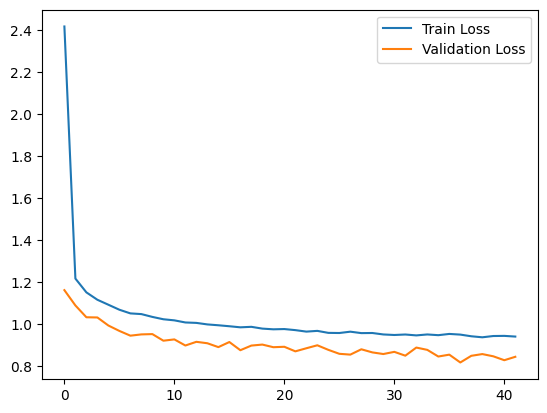

In [16]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

Overfitting Analysis: Plot both training and validation accuracy curves. A significant gap between training and validation accuracy indicates overfitting.



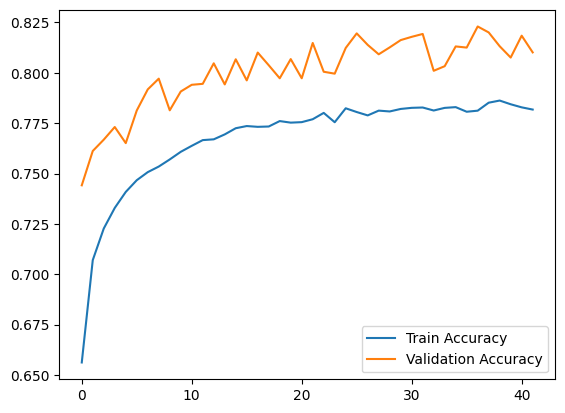

In [17]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()
